## Packages

In [1]:
%matplotlib inline
%pylab inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import librosa
import librosa.display
import os
import scipy.io.wavfile
import numpy as np
import sys
import pandas as pd
import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, AveragePooling1D, BatchNormalization, Input, Flatten, Dropout, Activation
from keras.utils import to_categorical, np_utils
import fetch_label
from tqdm import notebook
from IPython.display import clear_output

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


## Reading audio data

In [7]:
Train_data_path = './Audio_Speech_Actors_01-24'
mylist = []
for path, subdirs, files in os.walk(Train_data_path):
    for name in files:
        mylist.append(os.path.join(path, name))

In [8]:
print('Example file\n',mylist[0])

Example file
 ./Audio_Speech_Actors_01-24/Actor_09/03-01-07-01-02-01-09.wav


Filename Identifiers:
    
1. Modality (01 = full-AV, 02 = video-only, 03 = audio-only).\
2. Vocal channel (01 = speech, 02 = song).\
3. Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).\
4. Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the ‘neutral’ emotion.\
5. Statement (01 = “Kids are talking by the door”, 02 = “Dogs are sitting by the door”).\
6. Repetition (01 = 1st repetition, 02 = 2nd repetition).\
7. Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).\

## Plotting a sample audio file

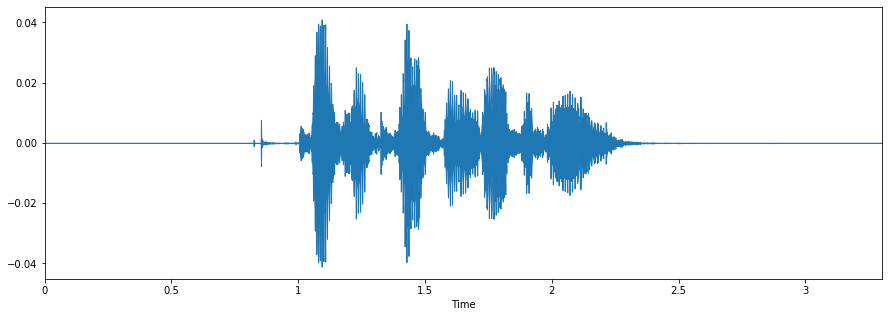

In [9]:
file_path='./Audio_Speech_Actors_01-24/Actor_01/03-01-01-01-01-01-01.wav'
data, sampling_rate = librosa.load(file_path)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

## Extract features from audio using librosa

In [10]:
def get_features_df():
    label = fetch_label.FetchLabel()
    df = pd.DataFrame(columns=['feature','emotion'])
    idx=0
    for index,y in enumerate(notebook.tqdm(mylist)):
        X, sample_rate = librosa.load(y, res_type='kaiser_fast',duration=3,sr=22050*2,offset=0.5)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        emotion = label.get_emotion(y)
        emotion=emotion.replace('female_', '') # making file names gender agnostic
        emotion=emotion.replace('male_', '')
        df.loc[idx] = [mfccs, emotion]
        idx=idx+1
    return df

In [11]:
df = get_features_df()
df

,feature,emotion
0,"[-73.24139, -73.55329, -71.55998, -69.435104, ...",disgusted
1,"[-68.52591, -68.52591, -68.52591, -68.52591, -...",happy
2,"[-74.32096, -74.32096, -74.32096, -74.32096, -...",sad
3,"[-44.88586, -45.08242, -47.0765, -46.61029, -4...",happy
4,"[-70.07857, -70.97567, -73.16718, -65.0323, -6...",sad
...,...,...
1435,"[-59.211617, -58.68752, -59.09467, -59.007286,...",happy
1436,"[-63.73215, -63.73215, -63.73215, -63.73215, -...",sad
1437,"[-57.67239, -58.34681, -58.55408, -57.433388, ...",happy
1438,"[-63.410885, -63.410885, -63.410885, -63.41088...",disgusted


In [119]:
df['emotion'].value_counts()

calm         192
surprised    192
angry        192
sad          192
disgusted    192
happy        192
fearful      192
neutral       96
Name: emotion, dtype: int64

## Data Preprocessing

In [25]:
feature_df = pd.DataFrame(df['feature'].values.tolist())
print('Original df shape: ', feature_df.shape)

labelled_df = pd.concat([feature_df,df['emotion']], axis=1)
df_cleaned = labelled_df.dropna(0)
print('Cleaned df shape: ', df_cleaned.shape)

shuffled_df = df_cleaned.sample(frac=1).reset_index(drop=True)
#shuffled_df = shuffled_df.loc[~shuffled_df['emotion'].isin(['neutral', 'disgusted', 'surprised'])]

Original df shape:  (1440, 259)
Cleaned df shape:  (1063, 260)


In [30]:
X_train, X_test, y_train, y_test = train_test_split(shuffled_df.drop('emotion', axis =1), shuffled_df['emotion'], test_size=0.1, random_state=0, shuffle = True)

## Saving encoded labels
### for use during prediction

In [31]:
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))
np.save('label_classes.npy', lb.classes_)

## Expanding dimensions for modelling 
### (batch, timesteps, feature_vector_size)

In [32]:
x_train_exp = np.expand_dims(X_train, axis=2)
x_test_exp = np.expand_dims(X_test, axis=2)

In [33]:
x_train_exp.shape

(956, 259, 1)

## Model Architecture and Training

In [34]:
class LivePlot(keras.callbacks.Callback):
    
    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses and accuracies
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []
    
    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        
        # Append the logs, losses and accuracies to the lists
        if epoch>3:
            self.logs.append(logs)
            self.losses.append(logs.get('loss'))
            self.acc.append(logs.get('accuracy'))
            self.val_losses.append(logs.get('val_loss'))
            self.val_acc.append(logs.get('val_accuracy'))
        
        # Before plotting ensure at least 2 epochs have passed
        if len(self.losses) > 3:
            
            # Clear the previous plot
            clear_output(wait=True)
            N = np.arange(0, len(self.losses))
            
            # You can chose the style of your preference
            # print(plt.style.available) to see the available options
            plt.style.use("seaborn")
            
            # Plot train loss, train acc, val loss and val acc against epochs passed
            plt.figure()
            plt.plot(N, self.losses, label = "train_loss")
            plt.plot(N, self.acc, label = "train_acc")
            plt.plot(N, self.val_losses, label = "val_loss")
            plt.plot(N, self.val_acc, label = "val_acc")
            plt.title("Training Loss and Accuracy [Epoch {}]".format(epoch))
            plt.xlabel("Epoch #")
            plt.ylabel("Loss/Accuracy")
            plt.legend()
            plt.show()

plot_losses = LivePlot()

In [74]:
def build_model():
    model = Sequential()

    model.add(Conv1D(256, 5,padding='same',input_shape=(x_train_exp.shape[1],1)))
    model.add(Activation('relu'))
    
    model.add(Conv1D(128, 5,padding='same', ))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=(5)))
    
    model.add(Conv1D(128, 5,padding='same',))
    model.add(Activation('relu'))
    
    model.add(Conv1D(128, 5,padding='same',))
    model.add(Activation('relu'))
    
    model.add(Conv1D(128, 5,padding='same',))
    model.add(Activation('relu'))
    
    model.add(Conv1D(128, 5,padding='same',))
    model.add(Activation('relu'))
    
    model.add(Flatten())
    model.add(Dense(8))
    model.add(Activation('softmax'))
    
    opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
    
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

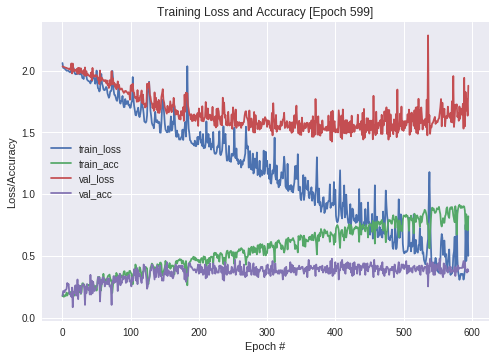

In [113]:
model = build_model()
history = model.fit(x_train_exp, 
                    y_train, 
                    batch_size=1024, 
                    epochs=600,
                    validation_data = [x_test_exp, y_test], 
                    callbacks=[plot_losses], 
                    verbose=1)

In [130]:
model.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_101 (Conv1D)          (None, 259, 256)          1536      
_________________________________________________________________
activation_126 (Activation)  (None, 259, 256)          0         
_________________________________________________________________
conv1d_102 (Conv1D)          (None, 259, 128)          163968    
_________________________________________________________________
activation_127 (Activation)  (None, 259, 128)          0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 259, 128)          0         
_________________________________________________________________
max_pooling1d_26 (MaxPooling (None, 32, 128)           0         
_________________________________________________________________
conv1d_103 (Conv1D)          (None, 32, 128)         

## Model Evaluation

In [114]:
train_result = model.evaluate(x_train_exp, y_train, verbose=0)
test_result = model.evaluate(x_test_exp, y_test, verbose=0)

print("train acc","%s: %.2f%%" % (model.metrics_names[1], train_result[1]*100))
print("test acc","%s: %.2f%%" % (model.metrics_names[1], test_result[1]*100))

train acc accuracy: 77.82%
test acc accuracy: 37.38%


## Saving weights

In [115]:
model_name = 'weight.h5'
save_dir = os.path.join(os.getcwd(), 'experiments/4')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /home/hs/Desktop/Projects/speech_emotion_recognition/emotion-recognition/experiments/4/weight.h5 
